<a href="https://colab.research.google.com/github/harrymarry1027/Learninglearning_healthcare/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("NevenaD/MedNurse-QA")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

MedNurse-QA.parquet:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/21643 [00:00<?, ? examples/s]

In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'sub-chapter', 'chapter ', 'book'],
        num_rows: 21643
    })
})

### 데이터 확인

In [3]:
ds['train'][0]

{'question': 'What is effective communication?',
 'answer': 'Effective communication requires a sender, a clear message, and a receiver who can decode and interpret the message.',
 'sub-chapter': 'basic communication concepts',
 'chapter ': 'communication',
 'book': 'nursing fundamentals'}

In [4]:
for i in range(3):
    print(f"[{i}] 질문:", ds['train'][i]['question'])
    print("답변:", ds['train'][i]['answer'])
    print("-"*50)

[0] 질문: What is effective communication?
답변: Effective communication requires a sender, a clear message, and a receiver who can decode and interpret the message.
--------------------------------------------------
[1] 질문: What is the role of nurses in communication?
답변: Nurses help patients and their families understand healthcare needs and treatments using verbal, nonverbal, and written communication.
--------------------------------------------------
[2] 질문: What is verbal communication?
답변: Verbal communication is an exchange of information using words understood by the receiver in a way that conveys professional caring and respect.
--------------------------------------------------


In [7]:
n_total = len(ds)
n_total

1

### Pandas Data Frame으로 변환

In [10]:
import pandas as pd

df = pd.DataFrame(ds['train'])
df.head()

,question,answer,sub-chapter,chapter,book
0,What is effective communication?,"Effective communication requires a sender, a c...",basic communication concepts,communication,nursing fundamentals
1,What is the role of nurses in communication?,Nurses help patients and their families unders...,basic communication concepts,communication,nursing fundamentals
2,What is verbal communication?,Verbal communication is an exchange of informa...,basic communication concepts,communication,nursing fundamentals
3,What is the impact of medical jargon on commun...,Using medical jargon or slang may create an un...,basic communication concepts,communication,nursing fundamentals
4,Why is it important to assess the receiver's p...,It is important to adapt communication to meet...,basic communication concepts,communication,nursing fundamentals


In [11]:
df.info()
df.describe(include='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21643 entries, 0 to 21642
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question     21643 non-null  object
 1   answer       21643 non-null  object
 2   sub-chapter  21643 non-null  object
 3   chapter      21643 non-null  object
 4   book         21643 non-null  object
dtypes: object(5)
memory usage: 845.6+ KB


,question,answer,sub-chapter,chapter,book
count,21643,21643,21643,21643,21643
unique,20058,20429,277,51,3
top,Unexpected Findings,Amphotericin B,applying the nursing process,antimicrobials,nursing skills
freq,12,13,996,985,8844


### 컬럼별로 어떤 책/챕터가 있는지 보기

In [12]:
df['book'].value_counts()

,count
book,
nursing skills,8844
nursing fundamentals,6534
nursing pharmacology,6265


In [14]:
print(df.columns)

Index(['question', 'answer', 'sub-chapter', 'chapter ', 'book'], dtype='object')


In [15]:
df[['chapter ', 'sub-chapter']].drop_duplicates().head(10)

,chapter,sub-chapter
0,communication,basic communication concepts
59,communication,comunicationg with patients
244,communication,comunicationg with healthcare team members
263,communication,documentation
355,diverse patients,diverse patients
368,diverse patients,diverse patients basic concepts
434,diverse patients,patients' bill of rights
458,diverse patients,cultural competence
488,diverse patients,health disparities
547,diverse patients,culturally sensitive care


In [17]:
n_books = df['book'].nunique()
n_chapters = df['chapter '].nunique()
n_subchapters = df['sub-chapter'].nunique()

n_books, n_chapters, n_subchapters

(3, 51, 277)

In [18]:
df['q_len'] = df['question'].str.split().str.len()
df['a_len'] = df['answer'].str.split().str.len()

df[['q_len', 'a_len']].describe()

,q_len,a_len
count,21643.000000,21643.000000
mean,8.627085,10.471931
std,2.559117,4.354708
min,2.000000,1.000000
25%,7.000000,8.000000
50%,9.000000,10.000000
75%,10.000000,13.000000
max,29.000000,49.000000


### 데이터 분포가 어떻게 되어 있는지 확인

1) 해당 chapter에 포함된 질문-답변수
- 상위 chapter = 데이터셋에서 가장 많이 다뤄지는 주제

In [20]:
chapter_counts = (
    df.groupby('chapter ')
      .size()
      .reset_index(name='n_QA')
      .sort_values(by='n_QA', ascending=False)
)

chapter_counts.head(10)

,chapter,n_QA
6,antimicrobials,985
8,autonomic nervous system,893
0,IV therapy management,818
10,cardiovascular & renal systems,755
22,facilitation of elimination,735
44,safety,719
50,wound care,696
43,respiratory system,692
36,neurological assessments,681
5,analgesics & musculoskeletal system,624


In [21]:
chapter_counts['percentage'] = (
    chapter_counts['n_QA'] / len(df) * 100
).round(1)

chapter_counts.head(10)

,chapter,n_QA,percentage
6,antimicrobials,985,4.6
8,autonomic nervous system,893,4.1
0,IV therapy management,818,3.8
10,cardiovascular & renal systems,755,3.5
22,facilitation of elimination,735,3.4
44,safety,719,3.3
50,wound care,696,3.2
43,respiratory system,692,3.2
36,neurological assessments,681,3.1
5,analgesics & musculoskeletal system,624,2.9


In [22]:
subchapter_diversity = (
    df.groupby('chapter ')['sub-chapter']
      .nunique()
      .reset_index(name='n_subchapters')
      .sort_values(by='n_subchapters', ascending=False)
)

subchapter_diversity.head(10)

,chapter,n_subchapters
6,antimicrobials,19
8,autonomic nervous system,14
22,facilitation of elimination,12
36,neurological assessments,12
43,respiratory system,12
50,wound care,11
10,cardiovascular & renal systems,11
13,central nervous system,10
5,analgesics & musculoskeletal system,10
41,pharmacokinetics & pharmacodynamics,10


In [24]:
chapter_summary = (
    df.groupby('chapter ')
      .agg(
          n_QA=('question', 'count'),
          n_subchapters=('sub-chapter', 'nunique'),
          avg_answer_len=('answer', lambda x: x.str.split().str.len().mean())
      )
      .reset_index()
      .sort_values(by='n_QA', ascending=False)
)

chapter_summary.head(10)

,chapter,n_QA,n_subchapters,avg_answer_len
6,antimicrobials,985,19,7.860914
8,autonomic nervous system,893,14,6.500560
0,IV therapy management,818,6,10.694377
10,cardiovascular & renal systems,755,11,8.402649
22,facilitation of elimination,735,12,10.727891
44,safety,719,8,12.694019
50,wound care,696,11,9.653736
43,respiratory system,692,12,8.325145
36,neurological assessments,681,12,8.060206
5,analgesics & musculoskeletal system,624,10,8.125000


In [26]:
chapter_subchapters_df = (
    df[['chapter ', 'sub-chapter']]
      .drop_duplicates()
      .sort_values(['chapter ', 'sub-chapter'])
)

chapter_subchapters_df.head(100)

,chapter,sub-chapter
21019,IV therapy management,IV therapy site assessment & complications
20825,IV therapy management,blood collection & IV therapy assessment
21419,IV therapy management,checklist for discontinuing an IV
21105,IV therapy management,checklist for primary IV solution administration
21241,IV therapy management,checklist for secondary IV solution administra...
...,...,...
11282,central nervous system,CNS stimulants
11553,central nervous system,anti-parkinson's medications
11496,central nervous system,anticonvulsants
11334,central nervous system,antidepressants


No charts were generated by quickchart


### chapter -> sub-chapter 구조를 시각적으로 한눈에 보기

In [37]:
pairs = (
    df[['chapter', 'sub-chapter']]
    .drop_duplicates()
    .sort_values(['chapter', 'sub-chapter'])
)

for chapter, group in pairs.groupby('chapter'):
    print(f"\n📘 {chapter}")
    for sc in group['sub-chapter']:
        print(f"   └─ {sc}")


📘 IV therapy management
   └─ IV therapy site assessment & complications
   └─ blood collection & IV therapy assessment
   └─ checklist for discontinuing an IV
   └─ checklist for primary IV solution administration
   └─ checklist for secondary IV solution administration
   └─ intravenous therapy assessment

📘 abdominal assessment
   └─ checklist for abdominal assessment
   └─ gastrointestinal and genitourinary assessment
   └─ sample documentation

📘 administration of enteral medications 
   └─ assessments related to medication administration
   └─ basic concepts of administrating medications 
   └─ checklist for oral medication administration
   └─ checklist for rectal medication administration
   └─ cheklist for enteral tube medication administration

📘 administration of medications via other routes
   └─ basic concepts 
   └─ cheklist for transdermal, eye, ear, inhalation and vaginal routes medication administration

📘 administration of parenteral medications
   └─ administrating 

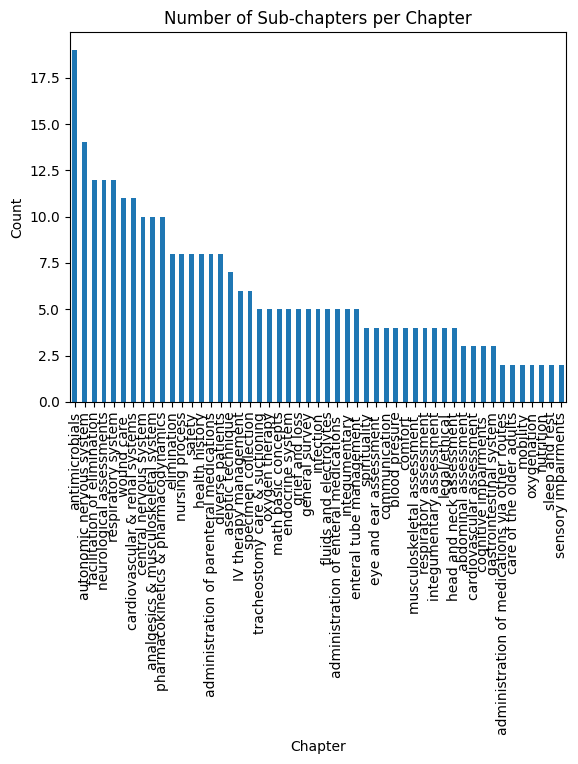

In [38]:
import matplotlib.pyplot as plt

sub_counts = (
    pairs.groupby('chapter')
    .size()
    .sort_values(ascending=False)
)

plt.figure()
sub_counts.plot(kind='bar')
plt.title('Number of Sub-chapters per Chapter')
plt.ylabel('Count')
plt.xlabel('Chapter')
plt.show()

Sunburs
- 구분된 체계를 이해하기 위한 시각화

In [40]:
import plotly.express as px

sun_df = (
    df.groupby(['chapter', 'sub-chapter'])
      .size()
      .reset_index(name='n_QA')
)

fig = px.sunburst(
    sun_df,
    path=['chapter', 'sub-chapter'],
    values='n_QA',
    title='Chapter–Subchapter Structure of MedNurse-QA'
)

fig.show()

Treemap
- 교육 콘텐츠 밀도가 직관적으로 보임

In [41]:
fig = px.treemap(
    sun_df,
    path=['chapter', 'sub-chapter'],
    values='n_QA',
    title='Treemap of Chapter and Subchapter Composition'
)

fig.show()

chapter 별 sub-chapter 수 비교

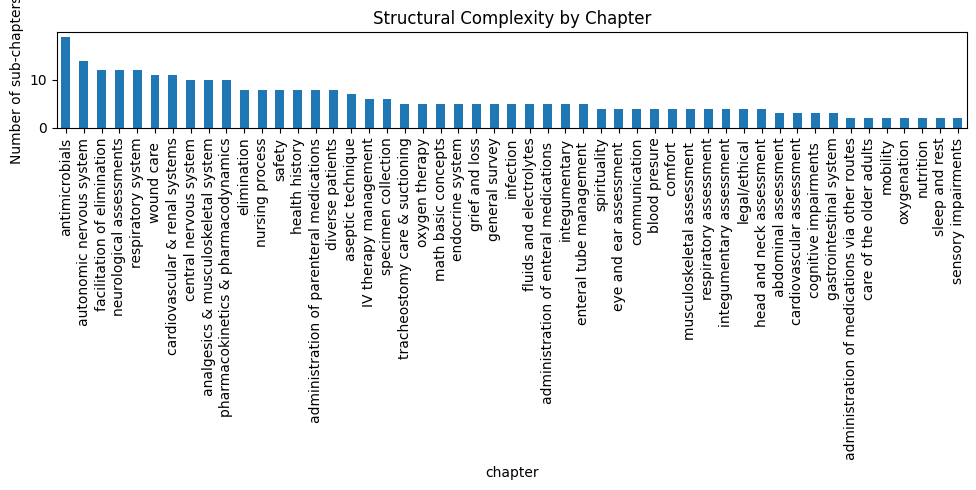

In [42]:
import matplotlib.pyplot as plt

sub_counts = (
    df[['chapter', 'sub-chapter']]
    .drop_duplicates()
    .groupby('chapter')
    .size()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
sub_counts.plot(kind='bar')
plt.ylabel('Number of sub-chapters')
plt.title('Structural Complexity by Chapter')
plt.tight_layout()
plt.show()

### 각 sub안에 어떤 내용이 있는지 확인

In [44]:
def sample_questions(x, n=2):
    return x.sample(min(len(x), n), random_state=42).tolist()

sub_examples = (
    df.groupby('sub-chapter')['question']
      .apply(sample_questions)
)

sub_examples.loc['acute pain, chronic pain, and musculoskeletal disorders']

['What is chronic pain?',
 'What are effective self-care strategies for chronic pain management?']

이 서브는 무엇을 반복해서 말하고 있는지?

In [45]:
from collections import Counter
import re

def top_keywords(texts, n=8):
    words = []
    for t in texts:
        words += re.findall(r'\b[a-z]{4,}\b', t.lower())
    return Counter(words).most_common(n)

sub_kw = (
    df.groupby('sub-chapter')['answer']
      .apply(top_keywords)
)

sub_kw.loc['intravenous therapy assessment']

[('site', 8),
 ('fluid', 7),
 ('overload', 7),
 ('complications', 6),
 ('risk', 5),
 ('prevent', 5),
 ('swelling', 5),
 ('infection', 4)]

In [46]:
for chapter, g in df.groupby('chapter'):
    print(f"\n📘 {chapter}")
    for sub, sg in g.groupby('sub-chapter'):
        print(f"  └─ {sub}  (n={len(sg)})")
        print("     ▸", sg['question'].iloc[0])


📘 IV therapy management
  └─ IV therapy site assessment & complications  (n=86)
     ▸ What is the primary concern when assessing a patient for IV therapy?
  └─ blood collection & IV therapy assessment  (n=157)
     ▸ What are the nurse's responsibilities in managing IV therapy?
  └─ checklist for discontinuing an IV  (n=224)
     ▸ What is the primary concern when assessing a patient for IV therapy?
  └─ checklist for primary IV solution administration  (n=136)
     ▸ What is the primary concern when assessing a patient for IV therapy?
  └─ checklist for secondary IV solution administration  (n=178)
     ▸ What is the primary concern when assessing a patient for IV therapy?
  └─ intravenous therapy assessment  (n=37)
     ▸ What is the primary concern when assessing a patient for IV therapy?

📘 abdominal assessment
  └─ checklist for abdominal assessment  (n=47)
     ▸ What are the initial steps before performing a gastrointestinal and genitourinary assessment?
  └─ gastrointestinal 

In [47]:
def show_qa(chapter, subchapter, n=10):
    out = df[(df['chapter']==chapter) & (df['sub-chapter']==subchapter)][
        ['question','answer','chapter','sub-chapter','book']
    ].head(n)
    return out

# 예시
show_qa('communication', 'basic communication concepts', n=10)

,question,answer,chapter,sub-chapter,book
0,What is effective communication?,"Effective communication requires a sender, a c...",communication,basic communication concepts,nursing fundamentals
1,What is the role of nurses in communication?,Nurses help patients and their families unders...,communication,basic communication concepts,nursing fundamentals
2,What is verbal communication?,Verbal communication is an exchange of informa...,communication,basic communication concepts,nursing fundamentals
3,What is the impact of medical jargon on commun...,Using medical jargon or slang may create an un...,communication,basic communication concepts,nursing fundamentals
4,Why is it important to assess the receiver's p...,It is important to adapt communication to meet...,communication,basic communication concepts,nursing fundamentals
5,How can verbal instructions be adapted for dif...,Verbal instructions can be adapted based on de...,communication,basic communication concepts,nursing fundamentals
6,What should a nurse do to verify patient under...,The nurse must always verify the patient’s und...,communication,basic communication concepts,nursing fundamentals
7,What is nonverbal communication?,Nonverbal communication includes facial expres...,communication,basic communication concepts,nursing fundamentals
8,What is the importance of nonverbal communicat...,Nonverbal communication is more powerful than ...,communication,basic communication concepts,nursing fundamentals
9,What percentage of communication is body langu...,55% of communication is body language.,communication,basic communication concepts,nursing fundamentals


In [50]:
def show_sub_qa(sub_name, n=10):
    tmp = df[df["sub-chapter"] == sub_name][["question", "answer", "chapter", "book"]].copy()
    return tmp.head(n)

# 예시: 하나 골라서 확인
example_sub = df["sub-chapter"].iloc[0]
show_sub_qa('IV therapy site assessment & complications', n=10)

,question,answer,chapter,book
21019,What is the primary concern when assessing a p...,Identifying potential complications such as al...,IV therapy management,nursing skills
21020,Why is it important to check for medication or...,To prevent allergic reactions that could lead ...,IV therapy management,nursing skills
21021,Which patient conditions increase the risk of ...,Congestive heart failure (CHF) and chronic kid...,IV therapy management,nursing skills
21022,How often should a child's IV site be assessed?,At least every hour for patency and signs of c...,IV therapy management,nursing skills
21023,What measures should be taken to prevent child...,Using joint stabilization that allows visual i...,IV therapy management,nursing skills
21024,Why should wooden tongue depressors not be use...,Due to the risk of fungal infections.,IV therapy management,nursing skills
21025,What are signs of fluid volume overload in old...,"Elevated blood pressure, increased respiratory...",IV therapy management,nursing skills
21026,How does aging affect vascular access for IV t...,Vein fragility due to loss of dermal thickness...,IV therapy management,nursing skills
21027,Why is it important to frequently monitor IV s...,"To prevent complications such as infiltration,...",IV therapy management,nursing skills
21028,How often should peripherally inserted IVs be ...,"At least every 4 hours, and every 1-2 hours fo...",IV therapy management,nursing skills


In [51]:
stop = set("""
a an the is are was were be been being to of and or in on for with as by from at into over
this that these those it its their them they we you your our can may might should would
what why how when where which who
""".split())

def tokenize(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if len(t) >= 3 and t not in stop]
    return tokens

def top_terms_for_sub(sub_name, topn=15):
    tmp = df[df["sub-chapter"] == sub_name]
    joined = (tmp["question"].fillna("") + " " + tmp["answer"].fillna("")).tolist()
    c = Counter()
    for s in joined:
        c.update(tokenize(s))
    return c.most_common(topn)

# 예시 실행
top_terms_for_sub('IV therapy site assessment & complications', topn=20)

[('catheter', 31),
 ('site', 25),
 ('prevent', 17),
 ('fluid', 14),
 ('risk', 14),
 ('patients', 14),
 ('complications', 13),
 ('infection', 13),
 ('therapy', 12),
 ('overload', 12),
 ('infusion', 12),
 ('infiltration', 10),
 ('phlebitis', 10),
 ('patient', 9),
 ('signs', 9),
 ('adults', 8),
 ('extravasation', 8),
 ('swelling', 8),
 ('nurse', 8),
 ('sites', 7)]

In [52]:
def short(text, n=140):
    text = str(text).replace("\n", " ")
    return text[:n] + ("..." if len(text) > n else "")

rows = []
for sub_name, g in df.groupby("sub-chapter"):
    n = len(g)
    sample_q1 = g["question"].iloc[0]
    sample_q2 = g["question"].iloc[1] if len(g) > 1 else ""
    sample_a  = g["answer"].iloc[0]
    top_terms = [w for w,_ in top_terms_for_sub(sub_name, topn=8)]
    rows.append({
        "sub-chapter": sub_name,
        "n": n,
        "sample_q1": short(sample_q1, 120),
        "sample_q2": short(sample_q2, 120),
        "sample_a": short(sample_a, 140),
        "top_terms": ", ".join(top_terms)
    })

sub_summary = pd.DataFrame(rows).sort_values("n", ascending=False)
sub_summary.head(20)

,sub-chapter,n,sample_q1,sample_q2,sample_a,top_terms
45,applying the nursing process,996,In what settings do nurses provide care for ol...,Why is it important for nurses to assess menta...,"Acute care facilities, clinics, adult day care...","patient, patients, does, pain, sleep, wound, i..."
70,basic concepts,920,What is the definition of growth in human deve...,How does development differ from growth?,Growth refers to the physical changes that occ...,"sleep, grief, does, patient, care, mobility, s..."
256,sample documentation,371,What is considered a normal blood pressure rea...,What does a blood pressure reading of 120/80 m...,A normal blood pressure reading is less than 1...,"documented, patient, noted, reports, oxygen, p..."
71,basic concepts,349,What role does patient education play in the n...,Why is delegation important in nursing?,Patient education empowers patients to manage ...,"catheter, medication, patient, prevent, used, ..."
108,checklist for discontinuing an IV,224,What is the primary concern when assessing a p...,Why is it important to check for medication or...,Identifying potential complications such as al...,"patient, site, before, catheter, prevent, remo..."
233,oxygenation basic concepts,221,What body systems contribute to a person’s oxy...,What is the primary function of the respirator...,"The respiratory, cardiovascular, and hematolog...","oxygen, blood, respiratory, does, carbon, diox..."
72,basic concepts of administrating medications,196,What determines a nurse's ability to administe...,Who can legally prescribe medications for admi...,A nurse's ability to administer medication is ...,"medication, medications, patient, administrati..."
27,antidiabetics,193,What are the endocrine and exocrine functions ...,What are the pancreatic islets responsible for?,The pancreas has an exocrine function of secre...,"insulin, glucose, acting, blood, hypoglycemia,..."
156,comunicationg with patients,185,What is assertive communication?,How does assertive communication differ from a...,Assertive communication is a way of conveying ...,"communication, patient, patients, therapeutic,..."
78,basic concepts of the cardiovascular & renal s...,185,Where is the human heart located?,What are the great veins and arteries attached...,The human heart is located within the thoracic...,"blood, heart, pressure, does, volume, affect, ..."
